In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Construccion VAE

### Encoder

In [ ]:
latent_dim = 2      # Dimension del espacio latente

encoder_inputs = keras.Input(shape=(28, 28, 1))                                           # Dimensiones de la imagen
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)    # Capa convolucional 1
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)                 # Capa convolucional 2
x = layers.Flatten()(x)                                                                   # Aplanamos
x = layers.Dense(16, activation="relu")(x)                                                # Capa densa
z_mean = layers.Dense(latent_dim, name="z_mean")(x)                                       # Capa para la media
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)                                 # Capa para la varianza
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")                # Definimos el modelo

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

### Sampler

Definimos una capa que genera muestras. Para esto, usamos una clase y heredamos las propiedades de ```layers.Layer```

In [ ]:
class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]                          # mean and variance shape
    z_size = tf.shape(z_mean)[1]                              # mean and variance shape
    epsilon = tf.random.normal(shape=(batch_size, z_size))    # normal distributed noise (0,1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon         # normal distributed sample

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))                                      # dimensiones de z
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)                        # dimensiones planas necesarias
x = layers.Reshape((7, 7, 64))(x)                                                     # dimensiones de imagen
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)    # capa convolucional transpuesta
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)    # capa convolucional transpuesta
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)        # capa convolucional
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

### VAE

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)

    # Asignamos en encoder, decoder y sampler creados previamente
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()

    # Asignamos funciones de perdida
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  # Definimos las métricas usadas
  @property
  def metrics(self):
    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

  # Definimos las métricas usadas
  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)        # Encode
      z = self.sampler(z_mean, z_log_var)           # Sample
      reconstruction = decoder(z)                   # Decode

      # Definimos las funciones de perdida
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
      grads = tape.gradient(total_loss, self.trainable_weights)

      # Parametros 'extra'
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {"total_loss": self.total_loss_tracker.result(),
              "reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "kl_loss": self.kl_loss_tracker.result(),}

## mnist

In [ ]:
import numpy as np

# Cargamos datos
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Declaramos el modelo
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

In [ ]:
# Entrenamos el modelo
vae.fit(mnist_digits, epochs=30, batch_size=1000)

Epoch 1/30
70/70 [==============================] - 164s 2s/step - total_loss: 191.0704 - reconstruction_loss: 189.5622 - kl_loss: 1.5082
Epoch 2/30
70/70 [==============================] - 164s 2s/step - total_loss: 180.2923 - reconstruction_loss: 177.9542 - kl_loss: 2.3381
Epoch 3/30
70/70 [==============================] - 150s 2s/step - total_loss: 169.3828 - reconstruction_loss: 166.4770 - kl_loss: 2.9058
Epoch 4/30
70/70 [==============================] - 154s 2s/step - total_loss: 165.1710 - reconstruction_loss: 162.3211 - kl_loss: 2.8499
Epoch 5/30
70/70 [==============================] - 151s 2s/step - total_loss: 162.5434 - reconstruction_loss: 159.6226 - kl_loss: 2.9207
Epoch 6/30
70/70 [==============================] - 149s 2s/step - total_loss: 160.7911 - reconstruction_loss: 157.8410 - kl_loss: 2.9501
Epoch 7/30
70/70 [==============================] - 152s 2s/step - total_loss: 158.9650 - reconstruction_loss: 155.9553 - kl_loss: 3.0097
Epoch 8/30
70/70 [================

1/1 [==============================] - 0s 31ms/step


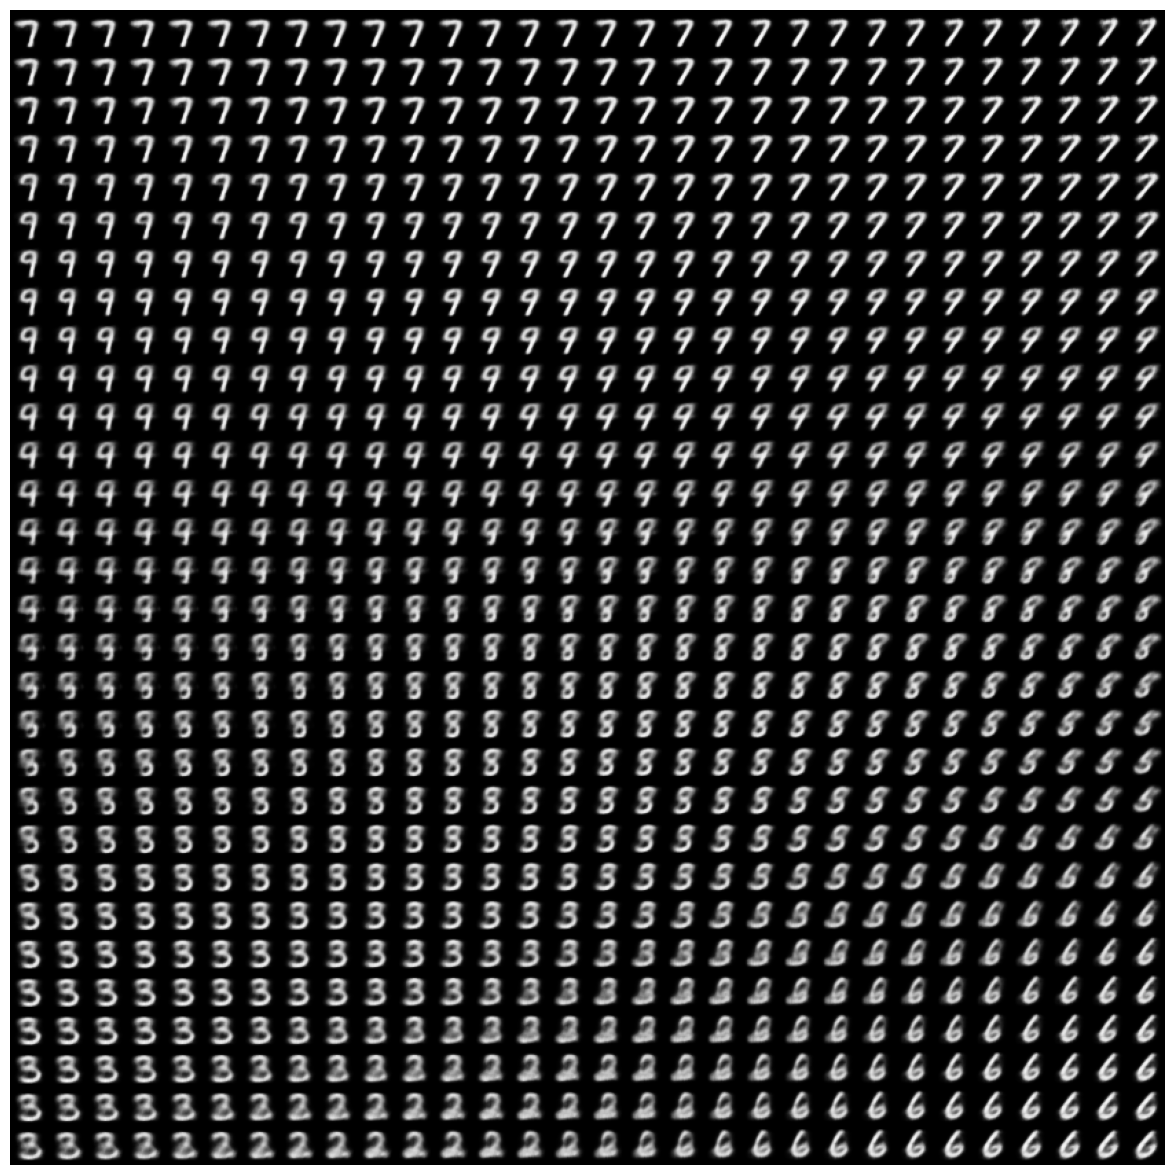

In [ ]:
import matplotlib.pyplot as plt

n = 30                                                  # Ploteamos 30x30 imagenes
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))     # Creamos la matriz de imagenes
grid_x = np.linspace(-1, 1, n)                          # Intervalo_x = [-1,...,1] para z
grid_y = np.linspace(-1, 1, n)[::-1]                    # Intervalo_y = [1,...,-1] para z

# Obtenemos la imagen para cada z = (x,y) en [-1,...,1]x[1,...,-1]
for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

# Configuraciones del plot
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")